OMNI_1_2025-7-15-12-56-14.csv
Record 0: Total Clock Cycles: 56464


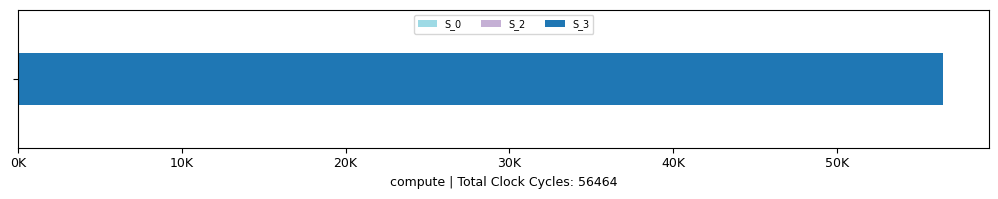

Record 1: Total Clock Cycles: 18833


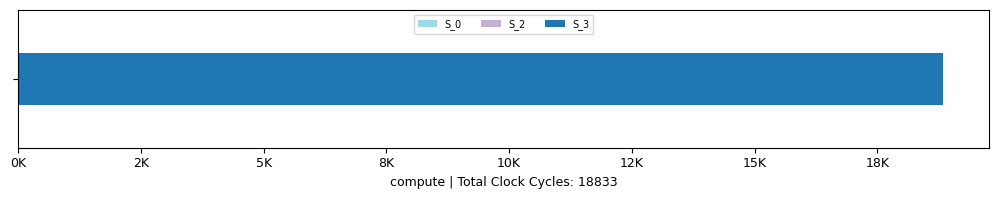

Record 2: Total Clock Cycles: 18833


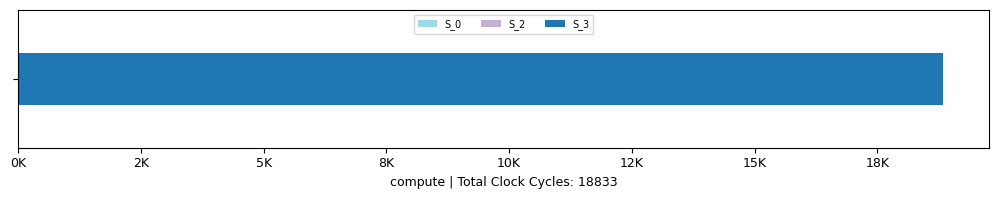

Record 3: Total Clock Cycles: 9425


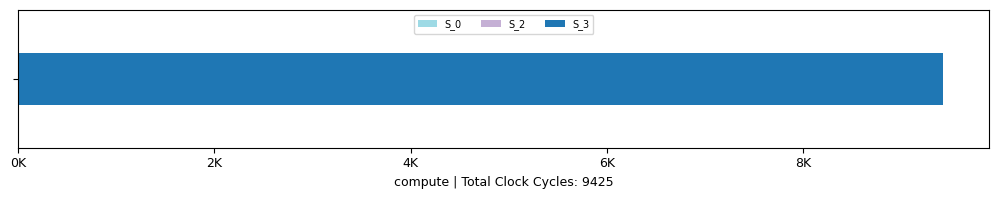

Record 4: Total Clock Cycles: 9425


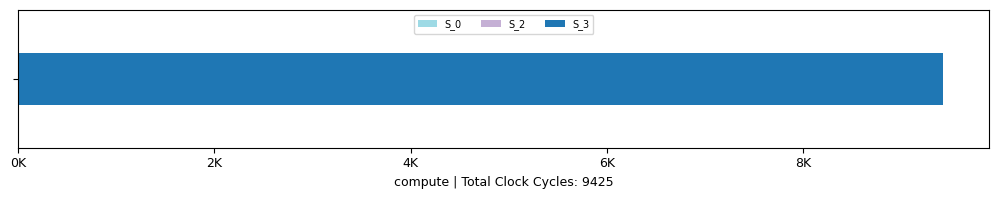

Record 5: Total Clock Cycles: 9425


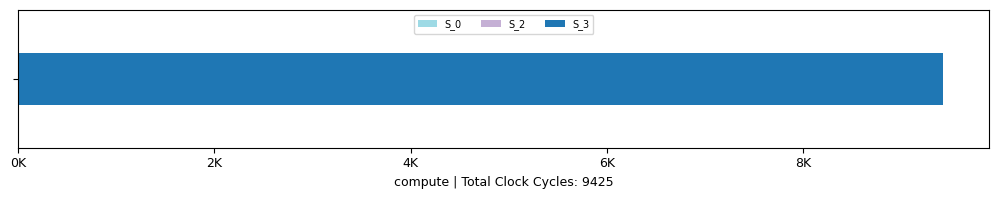

Record 6: Total Clock Cycles: 14129


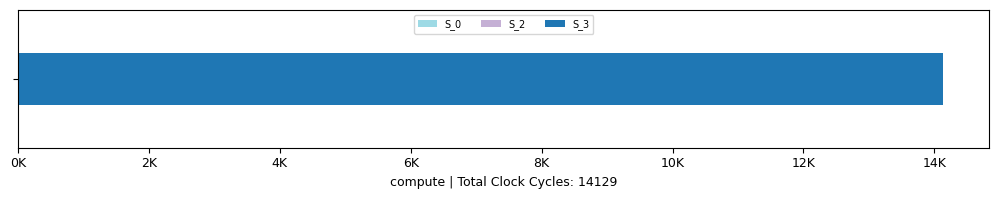

Record 7: Total Clock Cycles: 14129


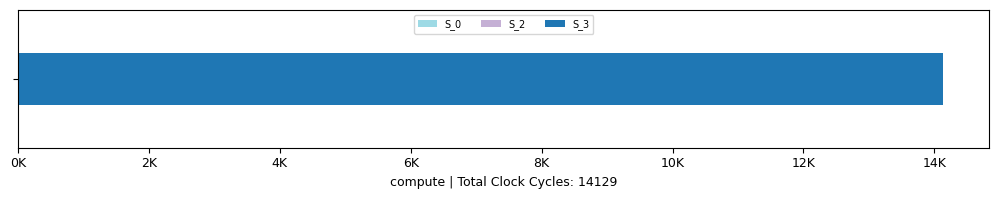

Record 8: Total Clock Cycles: 5897


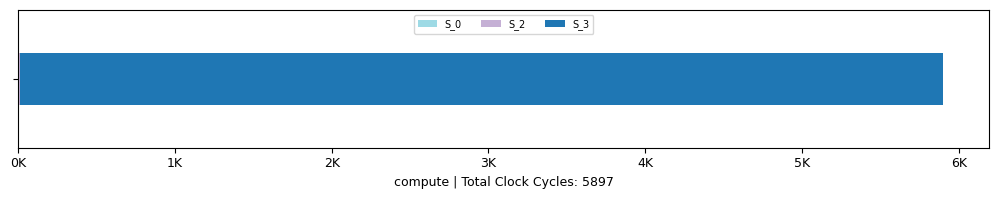

Record 9: Total Clock Cycles: 5897


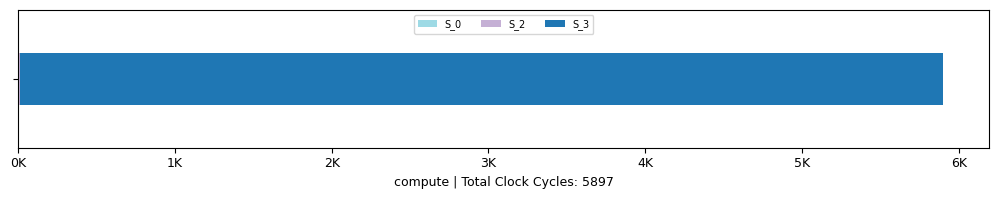

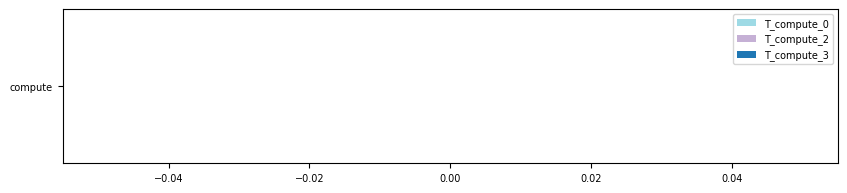

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker
import matplotlib
import os

def plot_profiles(folder, show_all=False, show_x=1):
    # cm = plt.get_cmap("Accent").reversed()
    cm = plt.get_cmap("tab20").reversed()
    NUM_COLORS = 7
    font = {"family": "sans-serif", "weight": "normal", "size": 7}
    matplotlib.rc("font", **font)

    def plot_h(df):
        for index, row in df.iterrows():
            early_exit = False
            for col in df.columns:
                if not col.startswith("T_"):
                    row = row.drop([col])

            T_rows = [row.split("_")[1] for row in df.columns if row.startswith("T_")]
            T_rows = list(set(T_rows))
            sdf = pd.DataFrame()
            Tlen = T_rows.__len__()
            fig, axs = plt.subplots(Tlen, 1, figsize=(10, Tlen * 2))
            # reorder T_rows alphabetically
            T_rows = sorted(T_rows)
            total_cycles = 0
            for id, T_row in enumerate(T_rows):
                all_T_row_cols = [row for row in df.columns if row.startswith("T_" + T_row)]
                ndf = df[all_T_row_cols].sort_values(by=0, axis=1, ascending=True)
                # ndf = df[all_T_row_cols]

                ndf = ndf.iloc[index]
                ndf = ndf.rename(T_row)
                ndf = ndf.to_frame().T
                ax = axs if Tlen == 1 else axs[id]
                pd.DataFrame(ndf).plot(
                    kind="barh", stacked=True, ax=ax, colormap=cm, width=0.3
                )
                ax.set_prop_cycle(color=[cm(5 + 1.0 * i) for i in range(NUM_COLORS)])
                legends = [
                    i.replace("T_", "").replace(T_row, "S") for i in list(ndf.columns)
                ]
                total_cycles = ndf.sum(axis=1).values[0]
                if total_cycles == 0:
                    early_exit = True
                    continue

                ax.legend(
                    legends,
                    loc="upper center",
                    bbox_to_anchor=(0.5, 1),
                    prop={"size": 7},
                    ncol=10,
                )

                ax.set_xlabel(f"{T_row} | Total Clock Cycles: {total_cycles}")
                ax.set_xlabel(ax.get_xlabel(), fontweight="normal", fontsize=9)
                ax.set_yticklabels("")
                ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: "{:,.0f}K".format(x/1000)))
                ax.tick_params(axis='both', which='major', labelsize=9)
                # add vertical line between all bar colour
                for i in range(1, len(legends)):
                    ax.axvline(x=i-0.5, color='black', linewidth=0.5)

            if early_exit:
                continue
            # plt.subplots_adjust(wspace=0.5, hspace=0.5/ Tlen)
            #make save between subplots bigger
            plt.tight_layout()
            plt.show()
            # break

    profs = sorted(os.listdir(folder), key=lambda x: os.path.getctime(folder + x))
    profs.reverse()
    for prof in profs:
        filename = folder + prof
        df = pd.read_csv(filename, sep=",", header=0)
        print(prof)
        plot_h(df)
        show_x -= 1
        if show_x == 0 and not show_all:
            break

# Example usage
profile_folder = "../../tensorflow/.data/vm_profs/"
# profile_folder = "..//benchmark_suite/.data/"

plot_profiles(profile_folder, show_all=False, show_x=1)


In [ ]:
import plotly.graph_objects as go

top_n = 5  # Number of top values to show in the plot
figure_height = 500
def plot_profile_interactive(filename):
  def plot_h(df):
    for index, row in df.iterrows():
      for col in df.columns:
        if not col.startswith("T_"):
          row = row.drop([col])

      T_rows = [row.split("_")[1] for row in df.columns if row.startswith("T_")]
      T_rows = list(set(T_rows))
      T_rows = sorted(T_rows)
      all_data = []
      total_cycles = 0
      for T_row in T_rows:
        all_T_row_cols = [row for row in df.columns if row.startswith("T_" + T_row)]
        ndf = df[all_T_row_cols].sort_values(by=0, axis=1, ascending=True)

        ndf = ndf.iloc[index]
        ndf = ndf.rename(T_row)
        ndf = ndf.to_frame().T
        ndf = ndf.T.nlargest(top_n, T_row).T  # Select top 5 values
        legends = [
          i.replace("T_", "").replace(T_row, "S") for i in list(ndf.columns)
        ]

        total_cycles = ndf.sum(axis=1).values[0]
        if total_cycles == 0:
          continue  # Skip if total cycles is zero
        for legend, value in zip(legends, ndf.values[0]):
          percentage = (value / total_cycles) * 100
          all_data.append((T_row, legend, value, percentage))
      if total_cycles == 0:
        continue  # Skip if total cycles is zero
      fig = go.Figure()
      for T_row, legend, value, percentage in all_data:
        fig.add_trace(go.Bar(
          y=[T_row],
          x=[value],
          orientation='h',
          name=legend,
          hovertext=f'{legend}: {value} ({percentage:.2f}%)',
          hoverinfo='text'
        ))

      fig.update_layout(
        title=f"Record {index}: Total Clock Cycles",
        barmode='stack',
        height=figure_height  # Adjust the height as needed
      )

      fig.update_traces(
        hoverlabel=dict(font=dict(color='black'))
      )

      fig.show()

  df = pd.read_csv(filename, sep=",", header=0)
  print("Processing file:", filename)
  plot_h(df)


def plot_profiles_interactive(folder, show_all=False, show_x=1):
  profs = sorted(os.listdir(folder), key=lambda x: os.path.getctime(folder + x))
  profs.reverse()
  for prof in profs:
    filename = folder + prof
    plot_profile_interactive(filename)
    show_x -= 1
    if show_x == 0 and not show_all:
      break

folder = "/home/jude/Workspace/SECDA-TFLite_v1.2/tensorflow/.data/"
# Example usage
plot_profiles(folder, show_all=False, show_x=1)

# plot_profile(folder, show_all=False, show_x=1)  # file path to a profile CSV file
# plot_profile("../../tensorflow/.data/OMNI_1_2025-7-15-12-56-14.csv")  # file path to a profile CSV file


Processing file: /home/jude/Workspace/SECDA-TFLite_v1.2/tensorflow/.data/OMNI_1_2025-7-15-12-56-14.csv
